In [98]:

%pip install pandas
%pip install matplotlib
%pip install codebleu
%pip install tree_sitter_python==0.21
%pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/6c/2a/e291c29670795406a824567d1dfc91db7b699799a002fdaa452bceea8f6e/scikit_learn-1.6.1-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for scipy>=1.6.0 from 

In [101]:
import pandas as pd
import matplotlib.pyplot as plt


In [102]:
results = pd.read_json("/Users/harishgokul/CodeRefineAI/dataset/P2/balanced_samples_gemini_codegen_submissions.json")
submission_details_df = pd.json_normalize(results['submission_details'])
results = results.drop(columns=['submission_details']).join(submission_details_df, rsuffix='_details')

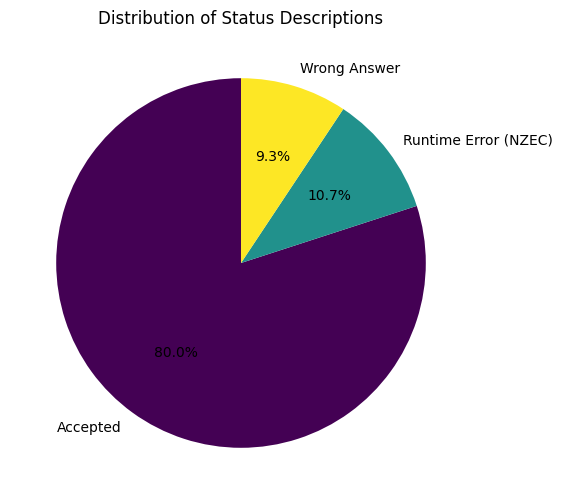

In [103]:
status_counts = results['status.description'].value_counts()
plt.figure(figsize=(10, 6))
status_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.title('Distribution of Status Descriptions')
plt.ylabel('') 
plt.show()

{'TypeError': np.int64(8), 'ImportError': np.int64(3), 'ModuleNotFoundError': np.int64(3), 'Others': np.int64(2)}


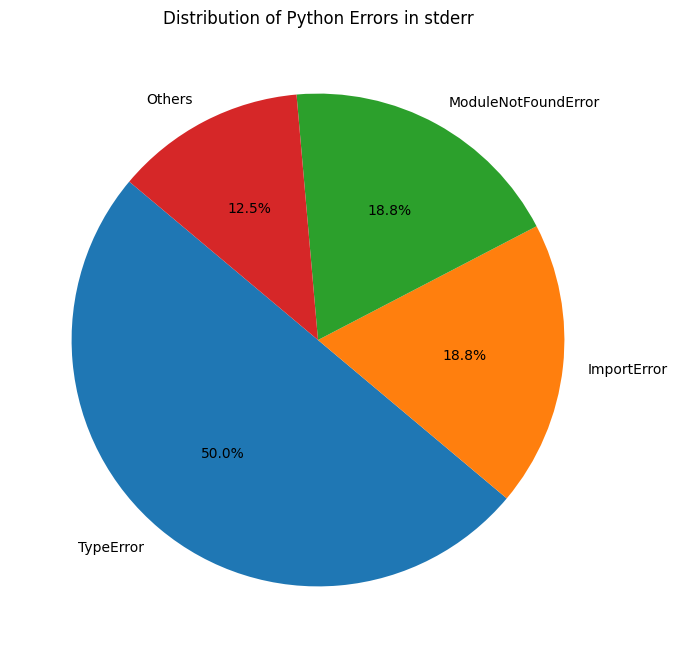

In [17]:
# Define common Python errors
python_errors = [
    "SyntaxError", "IndentationError", "TypeError", "NameError", "IndexError", "KeyError",
    "AttributeError", "ValueError", "ImportError", "ModuleNotFoundError", "ZeroDivisionError",
    "FileNotFoundError", "IOError", "EOFError", "RuntimeError", "RecursionError",
    "NotImplementedError", "AssertionError", "MemoryError", "OverflowError",
    "StopIteration", "UnboundLocalError", "PermissionError", "TimeoutError"
]

# Count occurrences of each error
error_counts = {error: df['stderr'].str.contains(rf"\b{error}\b", na=False).sum() for error in python_errors}

# Convert error counts into a DataFrame
error_df = pd.DataFrame(list(error_counts.items()), columns=["Error Type", "Count"])
error_df = error_df.sort_values(by="Count", ascending=False).reset_index(drop=True)

# Categorize errors: keep major ones, group smaller ones as "Others"
threshold = 1  # Errors with count <= threshold will be grouped as "Others"
filtered_errors = {err: count for err, count in error_counts.items() if count > threshold}
others_count = sum(count for err, count in error_counts.items() if count <= threshold)

# Add "Others" category if applicable
if others_count > 0:
    filtered_errors["Others"] = others_count

# Display DataFrame
print(filtered_errors)

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(filtered_errors.values(), labels=filtered_errors.keys(), autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Python Errors in stderr")
plt.show()


In [ ]:

def get_diff(codegen_file: str, reference_file: str):
    # Load the DataFrames
    codegen_df = pd.read_json(codegen_file)
    submission_details_df = pd.json_normalize(codegen_df['submission_details'])
    codegen_df = codegen_df.drop(columns=['submission_details']).join(submission_details_df, rsuffix='_details')

    reference_df = pd.read_json(reference_file)
    submission_details_df = pd.json_normalize(reference_df['submission_details'])
    reference_df = reference_df.drop(columns=['submission_details']).join(submission_details_df, rsuffix='_details')


    # Filter accepted solutions
    codegen_accepted = codegen_df[codegen_df['status.description'] == 'Accepted']
    reference_accepted = reference_df[reference_df['status.description'] == 'Accepted']

    # Initialize lists to store results
    faster_solutions = []
    more_memory_efficient_solutions = []

    # Compare performance for each question
    for question_id in codegen_accepted['question_id'].unique():
        codegen_solution = codegen_accepted[codegen_accepted['question_id'] == question_id]
        reference_solution = reference_accepted[reference_accepted['question_id'] == question_id]
        
        if not codegen_solution.empty and not reference_solution.empty:
            codegen_runtime = codegen_solution['time'].values[0]
            reference_runtime = reference_solution['time'].values[0]
            codegen_memory = codegen_solution['memory'].values[0]
            reference_memory = reference_solution['memory'].values[0]
            
            # Determine which solution is faster
            if codegen_runtime < reference_runtime:
                faster_solutions.append((question_id, 'codegen', codegen_runtime, reference_runtime))
            else:
                faster_solutions.append((question_id, 'reference', codegen_runtime, reference_runtime))
            
            # Determine which solution is more memory efficient
            if codegen_memory < reference_memory:
                more_memory_efficient_solutions.append((question_id, 'codegen', codegen_memory, reference_memory))
            else:
                more_memory_efficient_solutions.append((question_id, 'reference', codegen_memory, reference_memory))

    # Convert results to DataFrames
    
    faster_solutions_df = pd.DataFrame(faster_solutions, columns=['question_id', 'faster_solution', 'codegen_runtime', 'reference_runtime'])
    #more_memory_efficient_solutions_df = pd.DataFrame(more_memory_efficient_solutions, columns=['question_id', 'more_memory_efficient_solution', 'codegen_memory', 'reference_memory'])
    total = len(faster_solutions_df)
    count = (faster_solutions_df["faster_solution"] == "codegen").sum()
    return (count / total * 100)

In [100]:
# File paths
codegen_file = "/Users/harishgokul/CodeRefineAI/dataset/P2/balanced_samples_gemini_codegen_submissions.json"
reference_file_rt_eff = "/Users/harishgokul/CodeRefineAI/dataset/P2/balanced_samples_reference_rt_eff_submissions.json"
reference_file_rt_ineff = "/Users/harishgokul/CodeRefineAI/dataset/P2/balanced_samples_reference_rt_ineff_submissions.json"

print("Percentage of Generated Code Faster than Runtime Efficient Reference Solution", get_diff(codegen_file,reference_file_rt_eff))
print("Percentage of Generated Code Faster than Runtime Inefficient Reference Solution", get_diff(codegen_file,reference_file_rt_ineff))


Percentage of Generated Code Faster than Runtime Efficient Reference Solution 39.62264150943396
Percentage of Generated Code Faster than Runtime Inefficient Reference Solution 75.22123893805309
